In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('full transactions.csv', parse_dates=['SALE_DATE'])
df.head()

C:\Users\Will\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SALE_DATE,MODEL_YEAR,MAKE_NAME,MODEL_NAME,VEHICLE_NAME,SEGMENT,DATA_SOURCE,SALE_PRICE_AMOUNT,MSRP_AMOUNT,MILEAGE,...,DRIVETRAIN_DESCRIPTION,BEDLENGTH,BODY_STYLE,CAB_CONFIGURATION,DOOR_COUNT,TRUCK_FLG,TRANSACTION_GEOGRAPHY_ID,CITY_DISPLAY_NAME,STATE,SALE_TYPE
0,2016-12-31,2016,Mazda,CX-5,Sport SUV 4D,Compact SUV Crossover,LUTHER,25095.00,25795,-1,...,AWD,NaN,SUV,NaN,4,NaN,19077,Minneapolis,MN,Retail
1,2016-12-31,2016,Chevrolet,Silverado 2500 HD Double Cab,LT Pickup 4D 6 1/2 ft,Truck,VIN_SOLUTIONS,42693.00,48830,5,...,4WD,6.50,Pickup,Extended,4,NaN,40840,Saint Croix Falls,WI,Retail
2,2016-12-31,2016,Ford,Edge,Sport SUV 4D,Midsize SUV Crossover,VIN_SOLUTIONS,46312.89,47755,75,...,AWD,NaN,SUV,NaN,4,NaN,10925,El Paso,IL,Retail
3,2016-12-31,2017,Ram,2500 Crew Cab,Tradesman Pickup 4D 6 1/3 ft,Truck,VIN_SOLUTIONS,43290.12,45424,13,...,4WD,6.33,Pickup,Crew,4,NaN,22329,Reno,NV,Retail
4,2016-12-31,2016,Ram,1500 Crew Cab,SLT Pickup 4D 5 1/2 ft,Truck,VIN_SOLUTIONS,39676.87,44665,15,...,2WD,5.50,Pickup,Crew,4,NaN,36423,Arlington,TX,Retail


In [3]:
df = (df.rename(columns=str.lower)
 .drop(['engine_subtype', 'bedlength', 'cab_configuration', 'truck_flg'], axis=1)
 .dropna(subset=['city_display_name']))

In [4]:
df.days_in_inventory = df.days_in_inventory.fillna(value=df.days_in_inventory.mean()).astype(int)
df.transmission_type = df.transmission_type.fillna(value='Automatic')

In [5]:
cond = (df.transmission_num_of_speeds.isnull()) & (df.transmission_description.str.contains('\d')) 
df.loc[cond, 'transmission_num_of_speeds'] = df.loc[cond, 'transmission_description'].str.extract('(\d)')

C:\Users\Will\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [6]:
df.transmission_num_of_speeds = df.transmission_num_of_speeds.fillna(1)
df = df.loc[df.engine_type != 'Unknown']

df.transmission_num_of_speeds = df.transmission_num_of_speeds.astype(int)

In [7]:
df.loc[df.engine_cylinders.isnull(), ['engine_cylinders']] = 0
df.loc[df.engine_displacement.isnull(), 'engine_displacement'] = 0

In [8]:
df.engine_cylinders = df.engine_cylinders.astype(int)
df.engine_displacement = df.engine_displacement.astype(float)

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['transmission_type_le'] = le.fit_transform(df.transmission_type.values)

In [10]:
eng_type = pd.get_dummies(df.engine_type)
df = pd.concat([df, eng_type], axis=1)
df.head()

,sale_date,model_year,make_name,model_name,vehicle_name,segment,data_source,sale_price_amount,msrp_amount,mileage,...,city_display_name,state,sale_type,transmission_type_le,Diesel,Electric,Flexible Fuel,Gas,Hybrid,Natural Gas
0,2016-12-31,2016,Mazda,CX-5,Sport SUV 4D,Compact SUV Crossover,LUTHER,25095.00,25795,-1,...,Minneapolis,MN,Retail,0,0,0,0,1,0,0
1,2016-12-31,2016,Chevrolet,Silverado 2500 HD Double Cab,LT Pickup 4D 6 1/2 ft,Truck,VIN_SOLUTIONS,42693.00,48830,5,...,Saint Croix Falls,WI,Retail,0,0,0,1,0,0,0
2,2016-12-31,2016,Ford,Edge,Sport SUV 4D,Midsize SUV Crossover,VIN_SOLUTIONS,46312.89,47755,75,...,El Paso,IL,Retail,0,0,0,0,1,0,0
3,2016-12-31,2017,Ram,2500 Crew Cab,Tradesman Pickup 4D 6 1/3 ft,Truck,VIN_SOLUTIONS,43290.12,45424,13,...,Reno,NV,Retail,0,0,0,0,1,0,0
4,2016-12-31,2016,Ram,1500 Crew Cab,SLT Pickup 4D 5 1/2 ft,Truck,VIN_SOLUTIONS,39676.87,44665,15,...,Arlington,TX,Retail,0,0,0,0,1,0,0


In [11]:
df['discount'] = (df.sale_price_amount / df.msrp_amount - 1) * 100

In [12]:
df = df.loc[df.segment != 'Exotic']
df.segment.value_counts()

Compact SUV Crossover     67024
Midsize SUV Crossover     47569
Midsize Car               36745
Truck                     35715
Compact Car               34033
Fullsize SUV Crossover    12624
Near Luxury Car            8992
Midsize Truck              7278
Subcompact Car             6940
Minivan                    6696
Fullsize Car               5529
Midsize Luxury Car         3688
Van                        2848
Pony Car                   2807
Compact Sports Car         2014
Compact Luxury Car         1377
High End Luxury Car        1282
High Performance            972
Import Sports Car           928
Luxury Roadster             222
Sports Car                  164
Name: segment, dtype: int64

In [13]:
df.columns

Index(['sale_date', 'model_year', 'make_name', 'model_name', 'vehicle_name',
       'segment', 'data_source', 'sale_price_amount', 'msrp_amount', 'mileage',
       'days_in_inventory', 'transmission_description',
       'transmission_num_of_speeds', 'transmission_type', 'engine_description',
       'engine_cylinders', 'engine_displacement', 'engine_type',
       'drivetrain_description', 'body_style', 'door_count',
       'transaction_geography_id', 'city_display_name', 'state', 'sale_type',
       'transmission_type_le', 'Diesel', 'Electric', 'Flexible Fuel', 'Gas',
       'Hybrid', 'Natural Gas', 'discount'],
      dtype='object')

In [14]:
df = df.loc[df.drivetrain_description != 'Unknown']

In [15]:
df.drivetrain_description.value_counts()

FWD    113223
AWD     73239
4WD     58569
2WD     23493
RWD     16920
Name: drivetrain_description, dtype: int64

In [16]:
drivetrain_type = pd.get_dummies(df.drivetrain_description)
df = pd.concat([df, drivetrain_type], axis=1)
df.head()

,sale_date,model_year,make_name,model_name,vehicle_name,segment,data_source,sale_price_amount,msrp_amount,mileage,...,Flexible Fuel,Gas,Hybrid,Natural Gas,discount,2WD,4WD,AWD,FWD,RWD
0,2016-12-31,2016,Mazda,CX-5,Sport SUV 4D,Compact SUV Crossover,LUTHER,25095.00,25795,-1,...,0,1,0,0,-2.713704,0,0,1,0,0
1,2016-12-31,2016,Chevrolet,Silverado 2500 HD Double Cab,LT Pickup 4D 6 1/2 ft,Truck,VIN_SOLUTIONS,42693.00,48830,5,...,1,0,0,0,-12.568093,0,1,0,0,0
2,2016-12-31,2016,Ford,Edge,Sport SUV 4D,Midsize SUV Crossover,VIN_SOLUTIONS,46312.89,47755,75,...,0,1,0,0,-3.019809,0,0,1,0,0
3,2016-12-31,2017,Ram,2500 Crew Cab,Tradesman Pickup 4D 6 1/3 ft,Truck,VIN_SOLUTIONS,43290.12,45424,13,...,0,1,0,0,-4.697693,0,1,0,0,0
4,2016-12-31,2016,Ram,1500 Crew Cab,SLT Pickup 4D 5 1/2 ft,Truck,VIN_SOLUTIONS,39676.87,44665,15,...,0,1,0,0,-11.167872,1,0,0,0,0


In [17]:
cols = ['4WD','AWD','FWD','RWD','2WD','Diesel','Electric','Flexible Fuel', 'Gas', 'Hybrid','transmission_type_le', 'door_count', 'engine_displacement', 'engine_cylinders', 'days_in_inventory', 'transmission_num_of_speeds','mileage', 'msrp_amount', 'model_year', 'sale_price_amount']

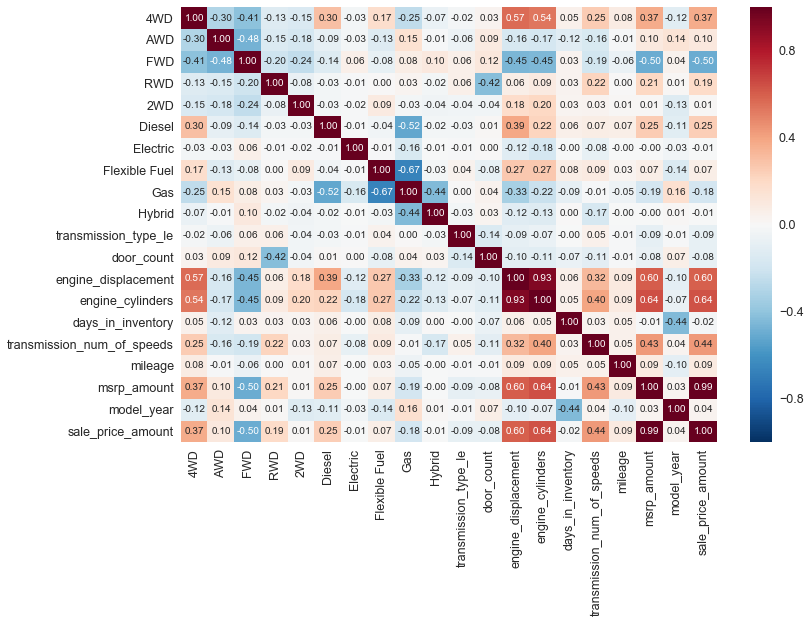

In [18]:
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
plt.rcParams['figure.figsize']=(12,8)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                fmt='.2f',
                annot_kws={'size': 10},
                yticklabels=cols,
                xticklabels=cols)

In [19]:
df[cols].head()

,4WD,AWD,FWD,RWD,2WD,Diesel,Electric,Flexible Fuel,Gas,Hybrid,transmission_type_le,door_count,engine_displacement,engine_cylinders,days_in_inventory,transmission_num_of_speeds,mileage,msrp_amount,model_year,sale_price_amount
0,0,1,0,0,0,0,0,0,1,0,0,4,2.5,4,32,6,-1,25795,2016,25095.00
1,1,0,0,0,0,0,0,1,0,0,0,4,6.0,8,108,6,5,48830,2016,42693.00
2,0,1,0,0,0,0,0,0,1,0,0,4,2.7,6,0,6,75,47755,2016,46312.89
3,1,0,0,0,0,0,0,0,1,0,0,4,6.4,8,19,6,13,45424,2017,43290.12
4,0,0,0,0,1,0,0,0,1,0,0,4,5.7,8,36,8,15,44665,2016,39676.87


## Linear Regression Model

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

X = df[cols].iloc[:, :-1]
y = df['sale_price_amount']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(Xtrain, ytrain)
y_train_pred = slr.predict(Xtrain)
y_test_pred = slr.predict(Xtest)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
print('MSE train: {:.3f}, test: {:.3f}'.format(mean_squared_error(ytrain, y_train_pred), mean_squared_error(ytest, y_test_pred)))

MSE train: 2903964.997, test: 2859187.354


In [22]:
from sklearn.metrics import r2_score
print('R^2 train: {:.3f}, test: {:.3f}'.format(r2_score(ytrain, y_train_pred), r2_score(ytest, y_test_pred)))

R^2 train: 0.988, test: 0.987


## Ridge Regression Model

In [23]:
alphas = 10**np.linspace(10,-2,100)*0.5
ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(Xtrain, ytrain)
ridgecv.alpha_

RidgeCV(alphas=array([  5.00000e+09,   3.78232e+09, ...,   6.60971e-03,   5.00000e-03]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

12.385381779958569

In [24]:
ridge2 = Ridge(alpha=ridgecv.alpha_)
ridge2.fit(Xtrain, ytrain)
print('Ridge MSE train: {:.3f}, test: {:.3f}'.format(mean_squared_error(ytrain, ridge2.predict(Xtrain)),
                                              mean_squared_error(ytest, ridge2.predict(Xtest))))

Ridge(alpha=12.385381779958569, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge MSE train: 2903966.028, test: 2859186.698


## LASSO Regression Model

In [25]:
lassocv2 = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lassocv2.fit(Xtrain, ytrain)
lassocv2.alpha_

LassoCV(alphas=array([  5.00000e+09,   3.78232e+09, ...,   6.60971e-03,   5.00000e-03]),
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=10000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

0.011550648500415791

In [26]:
lasso2 = Lasso(alpha=lassocv2.alpha_, max_iter=10000)
lasso2.fit(Xtrain, ytrain)
print('LASSO MSE train: {:.3f}, test: {:.3f}'.format(mean_squared_error(ytrain, lasso2.predict(Xtrain)),
                                                    mean_squared_error(ytest, lasso2.predict(Xtest))))

Lasso(alpha=0.011550648500415791, copy_X=True, fit_intercept=True,
   max_iter=10000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

LASSO MSE train: 2903965.085, test: 2859186.728


In [30]:
pd.Series(lasso2.coef_, index=X.columns)

4WD                           134.312974
AWD                           155.637512
FWD                          -171.283985
RWD                          -988.327663
2WD                             0.000000
Diesel                         -0.000000
Electric                     -836.053405
Flexible Fuel                 242.123034
Gas                            88.873518
Hybrid                       -116.268998
transmission_type_le          185.296306
door_count                   -357.216018
engine_displacement          -152.922318
engine_cylinders               50.302620
days_in_inventory              -1.411642
transmission_num_of_speeds     51.426777
mileage                         0.029674
msrp_amount                     0.933077
model_year                    212.811026
dtype: float64

In [27]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(Xtrain, ytrain)
print('Cross validated alpha: {:.3f}'.format(lassocv.alpha_))

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

Cross validated alpha: 247876.927


In [28]:
lasso = Lasso(alpha=lassocv.alpha_, max_iter=10000)
lasso.fit(Xtrain, ytrain)
print('LASSO MSE train: {:.3f}, test: {:.3f}'.format(mean_squared_error(ytrain, lasso.predict(Xtrain)),
                                                    mean_squared_error(ytest, lasso.predict(Xtest))))

Lasso(alpha=247876.92721978045, copy_X=True, fit_intercept=True,
   max_iter=10000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

LASSO MSE train: 3022704.257, test: 2982262.772


In [29]:
pd.Series(lasso.coef_, index=X.columns)

4WD                           0.000000
AWD                           0.000000
FWD                          -0.000000
RWD                          -0.000000
2WD                          -0.000000
Diesel                       -0.000000
Electric                     -0.000000
Flexible Fuel                 0.000000
Gas                           0.000000
Hybrid                       -0.000000
transmission_type_le          0.000000
door_count                   -0.000000
engine_displacement          -0.000000
engine_cylinders             -0.000000
days_in_inventory            -0.000000
transmission_num_of_speeds    0.000000
mileage                      -0.000000
msrp_amount                   0.933209
model_year                    0.000000
dtype: float64

## Elastic Net Regression Model

In [40]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
l1_ratio = [.1, .5, .9, .95, .99, 1]
enetcv = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, cv=10, max_iter=10000)
enetcv.fit(Xtrain, ytrain)
print('Alpha: {:.3f}, l1 ratio: {:.3f}'.format(enetcv.alpha_, enetcv.l1_ratio_))

ElasticNetCV(alphas=array([  5.00000e+09,   3.78232e+09, ...,   6.60971e-03,   5.00000e-03]),
       copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.9, 0.95, 0.99, 1], max_iter=10000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

Alpha: 0.009, l1 ratio: 0.990


In [41]:
enet = ElasticNet(alpha=enetcv.alpha_, l1_ratio=enetcv.l1_ratio_, max_iter=10000)
enet.fit(Xtrain, ytrain)
print('Elastic Net MSE train: {:.3f}, test: {:.3f}'.format(mean_squared_error(ytrain, enet.predict(Xtrain)),
                                                          mean_squared_error(ytest, enet.predict(Xtest))))

ElasticNet(alpha=0.008737642000038414, copy_X=True, fit_intercept=True,
      l1_ratio=0.98999999999999999, max_iter=10000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Elastic Net MSE train: 2903967.540, test: 2859187.646


## Parametrize Regression Methods

In [49]:
from sklearn.model_selection import cross_val_score

In [52]:
np.mean(cross_val_score(ElasticNet(alpha=enetcv.alpha_, l1_ratio=enetcv.l1_ratio_), X, y, scoring='neg_mean_squared_error', cv=10))

-2895527.8451076825

### Dropping MSRP and Engine Cylinders/Displacement

In [38]:
no_msrp_cyl = [i for i in cols if i not in ['msrp_amount','engine_cylinders']]
no_msrp_disp = [i for i in cols if i not in ['msrp_amount', 'engine_displacement']]